**AML2019**

## **Anomaly Detection**
---
_31<sup>th</sup> May 2019_

</br>

**Group-19: DO Thi Duyen - LE Ta Dang Khoa**

In [53]:
!pip install --user ruleset
!pip install --user graphviz

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import entropy
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.model_selection import GridSearchCV

from IPython.display import Image
from IPython.core.display import HTML 

from ruleset import *

import warnings
warnings.filterwarnings("ignore")

---
### **1. DATA EXPLORATION**

**FIRST,** let's take an overview look at the data, as well as some statistics.

In [2]:
# Load data
columns = ['SessionNumber', 'SystemID', 'Date', 'HighPriorityAlerts', 'Dumps', 'CleanupOOMDumps', 'CompositeOOMDums', 'IndexServerRestarts', 'NameServerRestarts', 'XSEngineRestarts', 'PreprocessorRestarts', 'DaemonRestarts', 'StatisticsServerRestarts', 'CPU', 'PhysMEM', 'InstanceMEM', 'TablesAllocation', 'IndexServerAllocationLimit', 'ColumnUnloads', 'DeltaSize', 'MergeErrors', 'BlockingPhaseSec', 'Disk', 'LargestTableSize', 'LargestPartitionSize', 'DiagnosisFiles', 'DiagnosisFilesSize', 'DaysWithSuccessfulDataBackups', 'DaysWithSuccessfulLogBackups', 'DaysWithFailedDataBackups', 'DaysWithFailedfulLogBackups', 'MinDailyNumberOfSuccessfulDataBackups', 'MinDailyNumberOfSuccessfulLogBackups', 'MaxDailyNumberOfFailedDataBackups', 'MaxDailyNumberOfFailedLogBackups', 'LogSegmentChange', 'Check1', 'Check2', 'Check3', 'Check4', 'Check5', 'Check6', 'Check7', 'Check8']
data = pd.read_csv('/mnt/datasets/anomaly/data.csv', sep=';', names=columns)
data[:3]

,SessionNumber,SystemID,Date,HighPriorityAlerts,Dumps,CleanupOOMDumps,CompositeOOMDums,IndexServerRestarts,NameServerRestarts,XSEngineRestarts,PreprocessorRestarts,DaemonRestarts,StatisticsServerRestarts,CPU,PhysMEM,InstanceMEM,TablesAllocation,IndexServerAllocationLimit,ColumnUnloads,DeltaSize,MergeErrors,BlockingPhaseSec,Disk,LargestTableSize,LargestPartitionSize,DiagnosisFiles,DiagnosisFilesSize,DaysWithSuccessfulDataBackups,DaysWithSuccessfulLogBackups,DaysWithFailedDataBackups,DaysWithFailedfulLogBackups,MinDailyNumberOfSuccessfulDataBackups,MinDailyNumberOfSuccessfulLogBackups,MaxDailyNumberOfFailedDataBackups,MaxDailyNumberOfFailedLogBackups,LogSegmentChange,Check1,Check2,Check3,Check4,Check5,Check6,Check7,Check8
0,0,0,16/01/2017 04:04,1,0.0,0.0,0.0,0,0,0,0,0,0,4.77,61.86,37.48,0.0,NaN,0,52884993.0,0.0,NaN,65.69,606600.0,6804.0,79.0,444366335.0,7,8,0,0,1,32,0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1,1,1,06/02/2017 04:03,0,0.0,0.0,0.0,0,0,0,0,0,0,1.05,32.82,12.77,0.0,NaN,0,65546255.0,0.0,NaN,45.60,1818555.0,6804.0,54.0,227400051.0,3,8,0,0,1,32,0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2,2,1,20/02/2017 04:03,0,0.0,0.0,0.0,0,0,0,0,0,0,0.66,35.16,13.00,0.0,NaN,0,59582212.0,0.0,NaN,18.94,1818505.0,6804.0,54.0,234913753.0,3,8,0,0,1,32,0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


1. There are 8 binary labels in the dataset. We can think it as 8 binary-classification models or as 1 multiclass-classification model.
2.  _SessionNumber_ and _SessionID_ are categorical variables, but display as numerical variables.
3. Relating to temporal features, we can analyze aspects such as: DayOfWeek, TimeOfDay, Weekend vs WeekDay,...which may affect to the frequency of anomaly. However, in this dataset, _Date_ is the date collection, not the date when the anomaly happen. Therefore, this feature does not mean a lot and we can drop it.

In [4]:
# Size of data
print('\nData size: ', data.shape)


Data size:  (287031, 44)


In [5]:
# Print count of missing values
print('\nMissing values:')
NAs = data.isna().sum()
display(pd.DataFrame(NAs[NAs>0]).transpose())


Missing values:


,Dumps,CleanupOOMDumps,CompositeOOMDums,CPU,PhysMEM,InstanceMEM,TablesAllocation,IndexServerAllocationLimit,DeltaSize,MergeErrors,BlockingPhaseSec,Disk,LargestTableSize,LargestPartitionSize,DiagnosisFiles,DiagnosisFilesSize,LogSegmentChange,Check1,Check2,Check3,Check4,Check5,Check6,Check7,Check8
0,3,3,3,25209,20567,22117,2290,26444,206,7733,75854,11379,16250,150,21923,21923,35549,24511,24486,22568,36647,35034,7384,35722,52


1. There are 25/44 columns which contain missing values, including 8 label columns.
2. The number of missing values in several column are quite large. For instance: _BlockingPhaseSec_ misses 75854 (~26.4%) values, _LogSegmentChange_ misses 35549 (~12.3%) values, _CPU_ misses 25209 (~8.8%) values. We should to be careful when imputing them.
3. The labels are missing information too. We will drop missing rows in these columns.

In [3]:
# Column name of labels
label_cols = [col for col in data.columns if 'Check' in col]

# Convert data type
cat_cols = ['SessionNumber', 'SystemID', 'MergeErrors']
for col in cat_cols:
    data[col] = data[col].astype(str)
data['Date'] = pd.to_datetime(data['Date'])

In [19]:
# Print count unique values of categorical features
print('\n\nCount unique values of categorical features: ')
display(pd.DataFrame(data[cat_cols].nunique(), columns=['CountUnique']))



Count unique values of categorical features: 


,CountUnique
SessionNumber,228196
SystemID,3188
MergeErrors,3


Feature _SessionNumber_ has too many unique values (228196). It is almost same as the row id since in average, every ~1.25 rows will belong to 1 session (287031/228196). We should drop this column.

In [22]:
# Print descriptive statistics of numerical features
print('\n\nDescriptive statistics of numerical features: ')
display(data[data.columns.difference(cat_cols + label_cols)].describe())



Descriptive statistics of numerical features: 


,BlockingPhaseSec,CPU,CleanupOOMDumps,ColumnUnloads,CompositeOOMDums,DaemonRestarts,DaysWithFailedDataBackups,DaysWithFailedfulLogBackups,DaysWithSuccessfulDataBackups,DaysWithSuccessfulLogBackups,DeltaSize,DiagnosisFiles,DiagnosisFilesSize,Disk,Dumps,HighPriorityAlerts,IndexServerAllocationLimit,IndexServerRestarts,InstanceMEM,LargestPartitionSize,LargestTableSize,LogSegmentChange,MaxDailyNumberOfFailedDataBackups,MaxDailyNumberOfFailedLogBackups,MinDailyNumberOfSuccessfulDataBackups,MinDailyNumberOfSuccessfulLogBackups,NameServerRestarts,PhysMEM,PreprocessorRestarts,StatisticsServerRestarts,TablesAllocation,XSEngineRestarts
count,2.111770e+05,261822.000000,287028.0,2.870310e+05,287028.000000,287031.0,287031.000000,287031.000000,287031.000000,287031.000000,2.868250e+05,265108.000000,2.651080e+05,2.756520e+05,287028.000000,287031.000000,260587.000000,287031.000000,264914.000000,2.868810e+05,2.707810e+05,251482.000000,287031.000000,287031.000000,287031.000000,287031.000000,287031.000000,2.664640e+05,287031.0,287031.000000,284741.000000,287031.000000
mean,3.559479e+03,12.504883,0.0,1.581218e+04,0.168935,0.0,0.196526,0.546850,5.923378,7.682710,6.832394e+09,250.991539,1.962630e+09,7.423645e+10,0.719658,2.798694,50.252361,0.096188,47.683065,3.349671e+08,2.933554e+08,1.326023,0.108013,81.020775,0.985367,121.915831,0.059784,1.992282e+02,0.0,0.003777,23.243752,0.054102
std,1.072371e+05,20.605688,0.0,9.221845e+04,1.909265,0.0,0.859692,1.528653,2.722940,2.249079,1.176211e+10,2640.173256,2.001116e+10,4.357427e+12,12.065531,2.690228,27.338611,1.921319,23.960828,4.225627e+08,3.811502e+08,119.418179,0.467463,872.701409,0.438451,144.410523,1.186495,1.522155e+04,0.0,0.085980,17.889126,1.026331
min,0.000000e+00,0.120000,0.0,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,3.000000,1.514934e+06,2.100000e-01,0.000000,0.000000,0.230000,0.000000,0.010000,0.000000e+00,0.000000e+00,-16887.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.020000e+00,0.0,0.000000,0.000000,0.000000
25%,4.000000e+00,2.950000,0.0,0.000000e+00,0.000000,0.0,0.000000,0.000000,5.000000,8.000000,1.666400e+09,75.000000,4.286505e+08,3.262000e+01,0.000000,1.000000,27.530000,0.000000,28.480000,4.025581e+07,3.791122e+07,0.000000,0.000000,0.000000,1.000000,36.000000,0.000000,4.655000e+01,0.0,0.000000,8.630000,0.000000
50%,2.000000e+01,6.460000,0.0,0.000000e+00,0.000000,0.0,0.000000,0.000000,7.000000,8.000000,3.718569e+09,110.000000,7.328700e+08,5.531000e+01,0.000000,2.000000,48.560000,0.000000,46.310000,1.322221e+08,1.132627e+08,0.000000,0.000000,0.000000,1.000000,102.000000,0.000000,7.004000e+01,0.0,0.000000,20.490000,0.000000
75%,2.140000e+02,14.900000,0.0,0.000000e+00,0.000000,0.0,0.000000,0.000000,8.000000,8.000000,9.471982e+09,157.000000,1.261116e+09,7.499000e+01,0.000000,4.000000,73.390000,0.000000,66.320000,4.915097e+08,4.115236e+08,0.000000,0.000000,0.000000,1.000000,134.000000,0.000000,8.645000e+01,0.0,0.000000,35.000000,0.000000
max,1.876111e+07,4602.490000,0.0,1.192000e+06,280.000000,0.0,13.000000,14.000000,14.000000,22.000000,1.280000e+12,356265.000000,1.730000e+12,3.731038e+14,1429.000000,24.000000,99.550000,341.000000,99.150000,2.147484e+09,2.147484e+09,10084.000000,63.000000,66017.000000,17.000000,7156.000000,159.000000,2.070680e+06,0.0,9.000000,94.600000,150.000000


Looking at the overall statistics, we can see that:

1. Features _CleanupOOMDumps_, _PreprocessorRestarts_, _DaemonRestarts_ are useless since all values of them are zeros.
2. There are errors in the dataset:
    - As described in the document, the maximum values of columns _CPU_, _PhysMEM_, _InstanceMEM_, _TablesAllocation_, _IndexServerAllocationLimit_, _Disk_ should be 100. In the table above, we see its maximum values exceed 100.
    - The document also states that values of _LogSegmentChange_ are non-negative, but the statistics shows that there are negative values in this columns.
3. The dataset contains a lot of outliers. However, we think outliers could reveal something about anomalies and should not be drop.

As mentioned above, we will remove the useless columns in the dataset.

In [4]:
# Drop useless columns
useless_cols = ['SessionNumber', 'CleanupOOMDumps', 'PreprocessorRestarts', 'DaemonRestarts', 'Date']
data.drop(useless_cols, inplace=True, axis=1)
cat_cols.remove('SessionNumber')

**SECOND,** we will explore the dataset corresponding to labels.

#### **A. LABEL EXPLORATION**

There are two approaches to solve this challenge: a multiclass classification model or 8 binary classification models. Let's take a look to both of them.

- **APPROACH 1:** MULTICLASS Classification

There are 8 binary labels, which means the dataset can have 256 (2<sup>8</sup>) possible values for the target.

In [5]:
pd.DataFrame(data[label_cols].dropna().astype('int64').sum(axis=1))[0].value_counts()

0    151299
1     63437
2     14052
3      5680
4      1783
5       307
6        46
7         7
Name: 0, dtype: int64

As can be seen from the output, there is:
- No value for the class _11111111_
- 7 values for 8 classes which contain at most 1 zero (_01111111_, _10111111_, _11011111_, _11101111_, _11110111_, _11111011_, _11111101_, _11111110_)
- 46 values for 56 classes which contain at most 2 zeros.
- etc.

In summary, we will not use this approach because of several reasons:
- The target has too many classes.
- The classes are extremly imbalanced, even several classes have no value.

- **APPROACH 2:** BINARY Classification

We define a function to compute the percent of anomaly in each label.

In [5]:
# A function to count anomaly and non-anomaly and to compute percent of anomaly
def ratio_labels(df, label_cols):
    """ Count anomaly and non-anomaly, compute percent of anomaly
    Parameters:
        df: DataFrame
        label_cols (list of string): List of label names
    Return:
        DataFrame: A dataframe with one column (cnt_non-anomaly, cnt-anomaly, percent_anomaly)
    """
    # Count values each label in the given list
    count_labels = df[label_cols].apply(pd.Series.value_counts)
    # Compute percent of anomaly
    ratio_labels = count_labels.apply(lambda x: (x[0], x[1], round(x[1]/x.sum(), 2)), axis=0)

    ratio_labels_df = pd.DataFrame(ratio_labels, columns=['(Normal, Anomaly, %Anomaly)'])
    return ratio_labels_df

In [6]:
ratio_all = ratio_labels(data, label_cols)
display(ratio_all)

,"(Normal, Anomaly, %Anomaly)"
Check1,"(260884, 1636, 0.01)"
Check2,"(253781, 8764, 0.03)"
Check3,"(256370, 8093, 0.03)"
Check4,"(225569, 24815, 0.1)"
Check5,"(248917, 3080, 0.01)"
Check6,"(199075, 80572, 0.29)"
Check7,"(243621, 7688, 0.03)"
Check8,"(284060, 2919, 0.01)"


As can be seen from the output, 8 labels have extremely imbalance binary classes.
- Model 1 (label _Check1_) has **1%** anomaly.
- Model 2 (label _Check2_) has **3%** anomaly.
- Model 3 (label _Check3_) has **3%** anomaly.
- Model 4 (label _Check4_) has **10%** anomaly.
- Model 5 (label _Check5_) has **1%** anomaly.
- Model 6 (label _Check6_) has **29%** anomaly.
- Model 7 (label _Check7_) has **3%** anomaly.
- Model 8 (label _Check8_) has **1%** anomaly.

Compare to approach 1, the approach 2 which are 8 binary classification tasks are much better. We will use it to solve the chalenge.

**Datasets**

Since the missing values of labels are different, we need 8 individual dataset for 8 labels. Here we define a function to create the dataset according to each label. The missing values of each label are removed in this function.

In [6]:
# A function to create a dataset for a given label
def get_data_by_label(df, label):
    """ Create a dataset for a given label
    Parameters:
        df (DataFrame): The original dataframe with multiple labels
        label (str): The given label
    Return: A dataframe with one given label
    """
    # Copy data where the given label is not null
    data = df[df[label].isna() == False].copy()
    # Convert type of the label from float to boolean
    data[label] = data[label].astype(bool)
    # Remove other labels
    data.drop(list(set(label_cols) - set([label])), axis=1, inplace=True)
    return data

We create 8 datasets for 8 models. These datasets are not preprocessed (it contains missing values, errors, outliers).

In [7]:
# Create 8 datasets which are not preprocessed for 8 labels
datasets_before_prep = []
for i in range(1, 9):
    df = get_data_by_label(data, 'Check%d'%i)
    datasets_before_prep.append(df)

#### **B. FEATURE EXLORATION**

**1. Categorical features**

For the categorical feature, we'll consider the percent of anomaly in each group. However, there are several groups which can have too few instances, so the percent of anomaly cannot reveal anything about these groups. Therefore, we consider both percent and count of anomaly.

In [7]:
# A function to compute percent and count of anomaly in each group of each feature
def anomaly_groupby_cat(data, cat_col, label):
    """ Compute percent and count of anomaly
    Parameters:
        data: DataFrame
        cat_col (list of string): List of names of categorical features
        label (str): Name of a given label
    Return:
        DataFrame which contains (count of non-anomaly, count of anomaly, percent of anomaly)
    """
    # Count anomaly and non-anomaly in each group of the feature
    df = pd.crosstab(data[cat_col], data[label])
    # Compute percent of anomaly
    df['PercentageOfAnomaly'] = df.apply(lambda r: r[True]*100/r.sum(), axis=1)
    # Sort dataframe by percent of anomaly
    df = df.sort_values(by=['PercentageOfAnomaly'], ascending=False)
    return df

In [8]:
# Create list of dataframes which contain percent and count of anomaly
groupby_anomalies = []
for i in range(1, 9):
    for col in cat_cols:
        groupby_anomaly = anomaly_groupby_cat(datasets_before_prep[i-1], col, 'Check%d'%i)
        groupby_anomalies.append(groupby_anomaly)

In [13]:
groupby_anomalies[1]

Check1,False,True,PercentageOfAnomaly
MergeErrors,,,
1.0,109062,704,0.641364
0.0,145546,901,0.615240
nan,6276,31,0.491517


- Here we plot percent and count of anomaly in a same plot. The left axis is the count and the right axis is the percent. The features are _SystemID_ and _MergeErrors_. The labels are from _Check1_ to _Check8_.

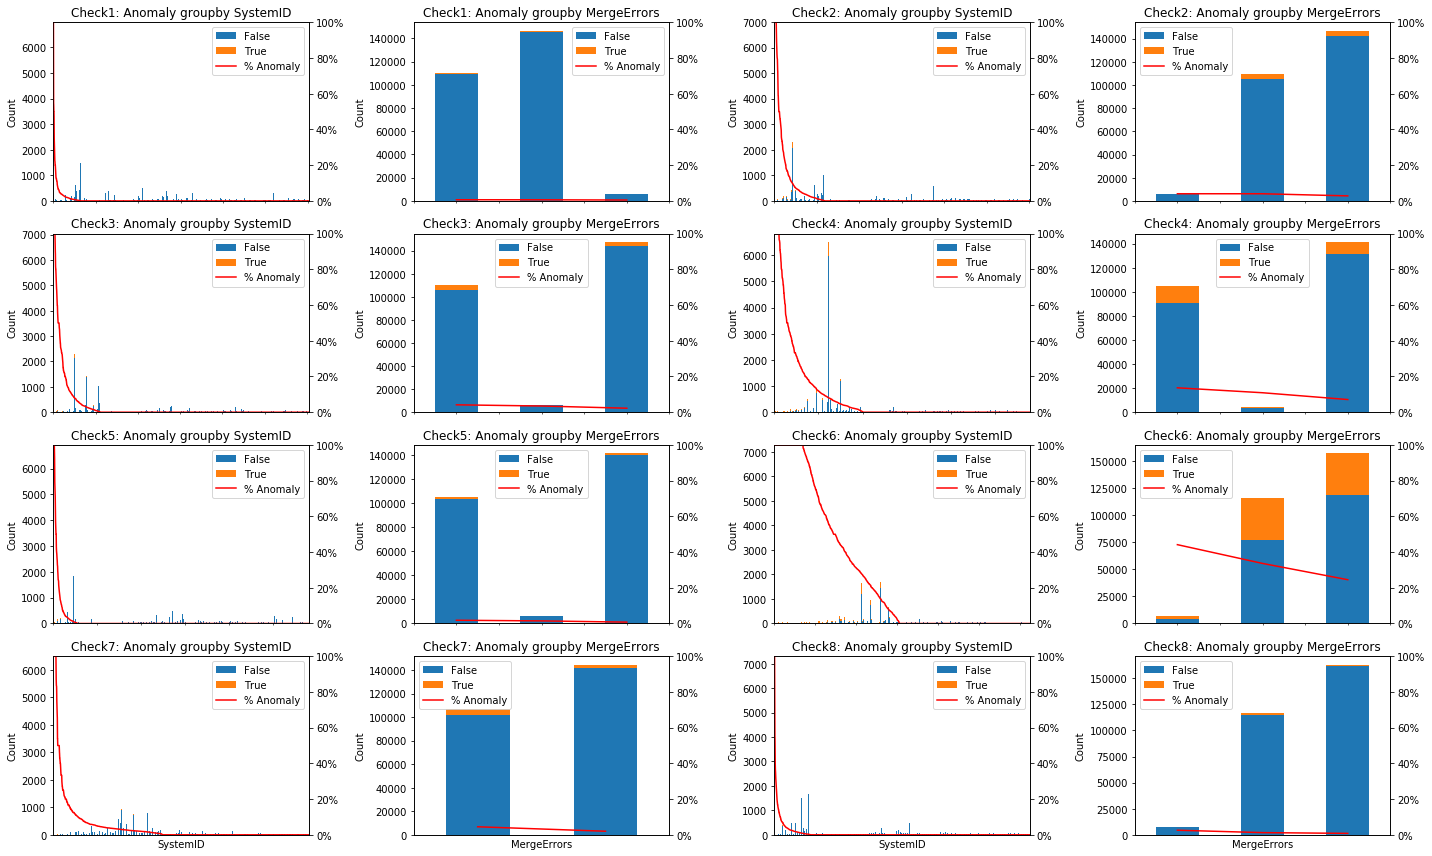

In [12]:
# Outline the Plot
fig, axes = plt.subplots(4, 4, figsize=(20, 12))

# Indexed and titled each subplot
subplot_idx = 0

# Plotting
for df in groupby_anomalies:

    row, col = divmod(subplot_idx, 4)
    ax1 = df.iloc[:, [0, 1]].plot.bar(stacked=True, legend=False, ax=axes[row, col])
    ax2 = df[:]['PercentageOfAnomaly'].plot(secondary_y=True, use_index=False, color='r', legend=False, ax=axes[row, col])
    ax2.set_ylim(0, 100)
    ax1.set_ylabel('Count')
    ax2.set_yticklabels(['{}%'.format(int(x)) for x in ax2.get_yticks()])
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    axes[row, col].legend(h1 + h2, l1 + ['% Anomaly'])
    plt.title('%s: Anomaly groupby %s' % (df.columns.name, df.index.name))
    plt.xticks([]);
    
    subplot_idx += 1

plt.tight_layout()

**COMMENT.**

The group which is strongly related to anomaly is the group having the high percent of anomaly and containing not too few instances (sample size). As can be seen from the plot of _SystemID_ and _Check4_ and the plot of _SystemID_ and _Check6_, there are several _SystemID_s which have the high percent of anomaly. That means perhaps there are problems inside some systems which caused the anomalies.

**2. Numerical features**

In [8]:
# List of numerical features
num_cols = data.columns.difference(useless_cols + cat_cols + label_cols).tolist()

**FIRST**, we'll explore the relationships between the **numeric attributes**.

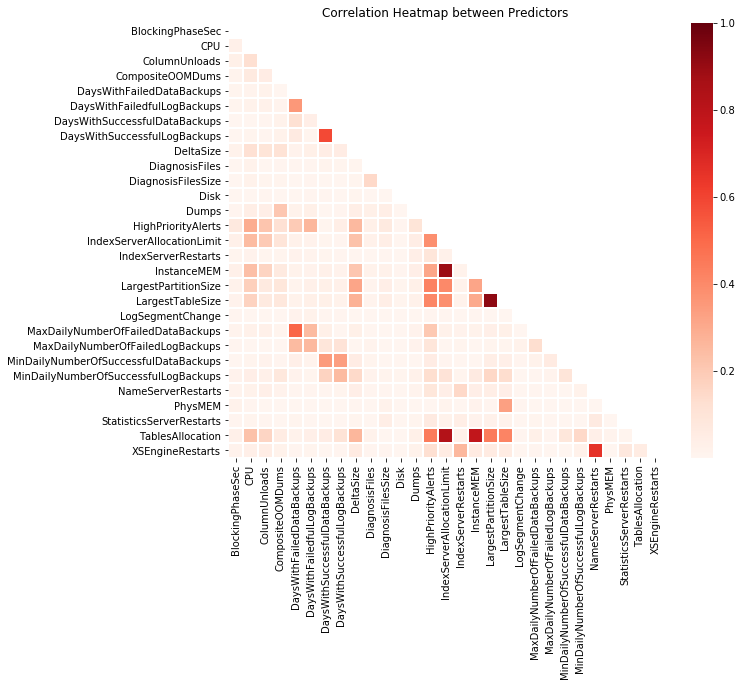

In [14]:
# Compute the ABSOLUTE correlation coefficients
numericCorrel = data[num_cols].corr().abs()

# Get the lower-left half of the square
mask = np.zeros_like(numericCorrel)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.title("Correlation Heatmap between Predictors")

sns.heatmap(numericCorrel, mask=mask, cmap="Reds", square=True, linewidths=1.)

plt.show()

We can see that:

1. _InstanceMEM_, _IndexServerAllocationLimit_ and _TablesAllocation_ are strongly correlated.
2. _LargestTableSize_ is strongly correlated to _LargestPartitionSize_.
3. _DaysWithSuccessfulLogBackups_ is strongly correlated to _DaysWithSuccessfulDataBackups_.
4. _MaxDailyNumberOfFailedLogBackups_ is strongly correlated to _MaxDailyNumberOfFailedDataBackups_.
5. _NameServerRestarts_ is strongly correlated to _XSEngineRestarts_
6. _LargestTableSize_ is strongly correlated to _LargestPartitionSize_
7. _HighPriorityAlerts_, _TablesAllocation_, _LargestTableSize_, _LargestPartitionSize_, _IndexServerAllocationLimit_ are correlated.

There are many correlated features in the dataset. This finding of correlated predictors is very useful in case we want to reduce the dimensions later.

**SECOND,** we'll explore the relationship between **numerical features and labels**.

Since there are many outliers in the datasets, we **hide it from graph** to observe subplots more obvious.

In [15]:
# A boxplot function to plot the numerical features and labels
def boxplot_numerical_features(data, cat_features, label, nrow, ncol, figsize):
    """ Plot the relationship between a numerical feature and a label
    Parameters:
        data: Dataframe
        cat_features: Categorical features
        label: A label name
        nrow, ncol, figsize: The number of rows, columns and the size of the figure
    """
    # Outline the Plot
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize)

    # Indexed and titled each subplot
    subplot_idx = 0

    # Plotting
    for feature in cat_features:
        row, col = divmod(subplot_idx, 10)
        ax = sns.boxplot(x=label, y=feature, data=data, ax=axes[row, col], showfliers=False)
        plt.xticks([]);
        subplot_idx += 1

    plt.tight_layout()

**Numerical features and label _Check1_**

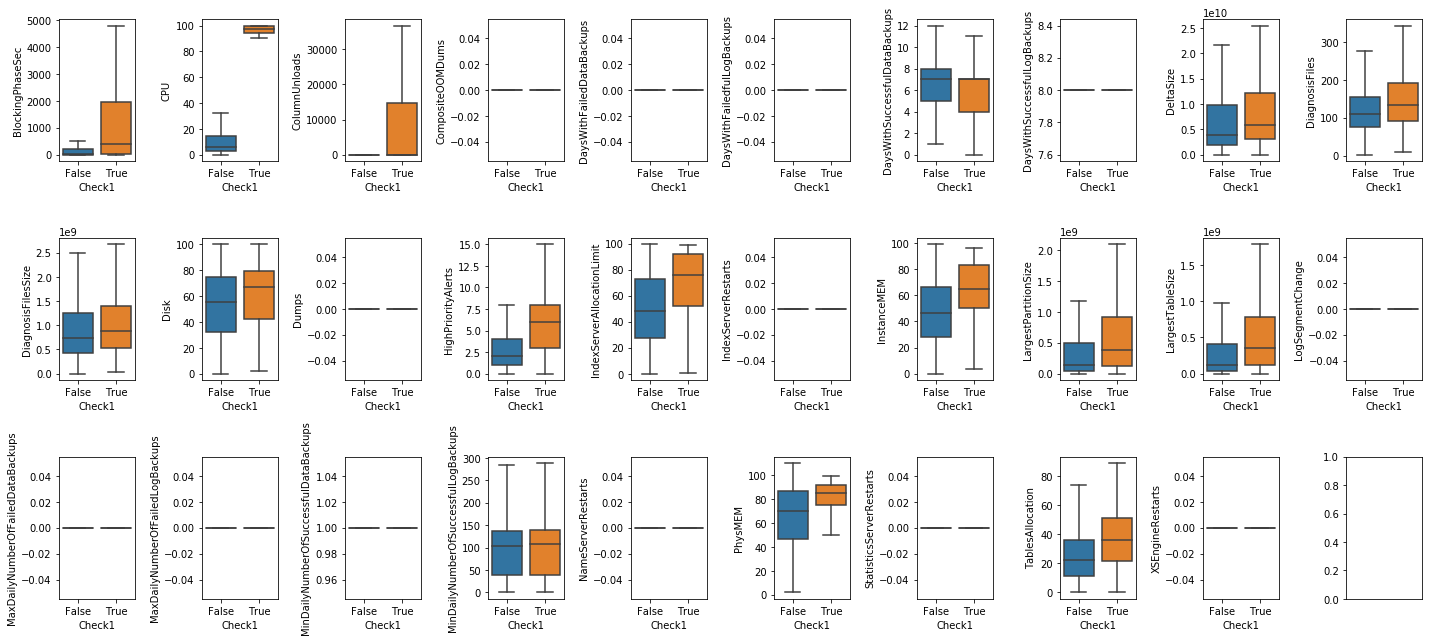

In [16]:
boxplot_numerical_features(datasets_before_prep[0], num_cols, "Check1", 3, 10, (20,9))

**COMMENT.**

For this label, feature _CPU_ is very useful and can help to separate classes comletely if there are not outliers in the dataset. The instances which have the _CPU_ usage over ~85 will belong to the anomaly class.

Besides that, there are other informative features such as _HighPriorityAlerts_, _PhysMEM_, etc.

**Numerical features and label _Check2_**

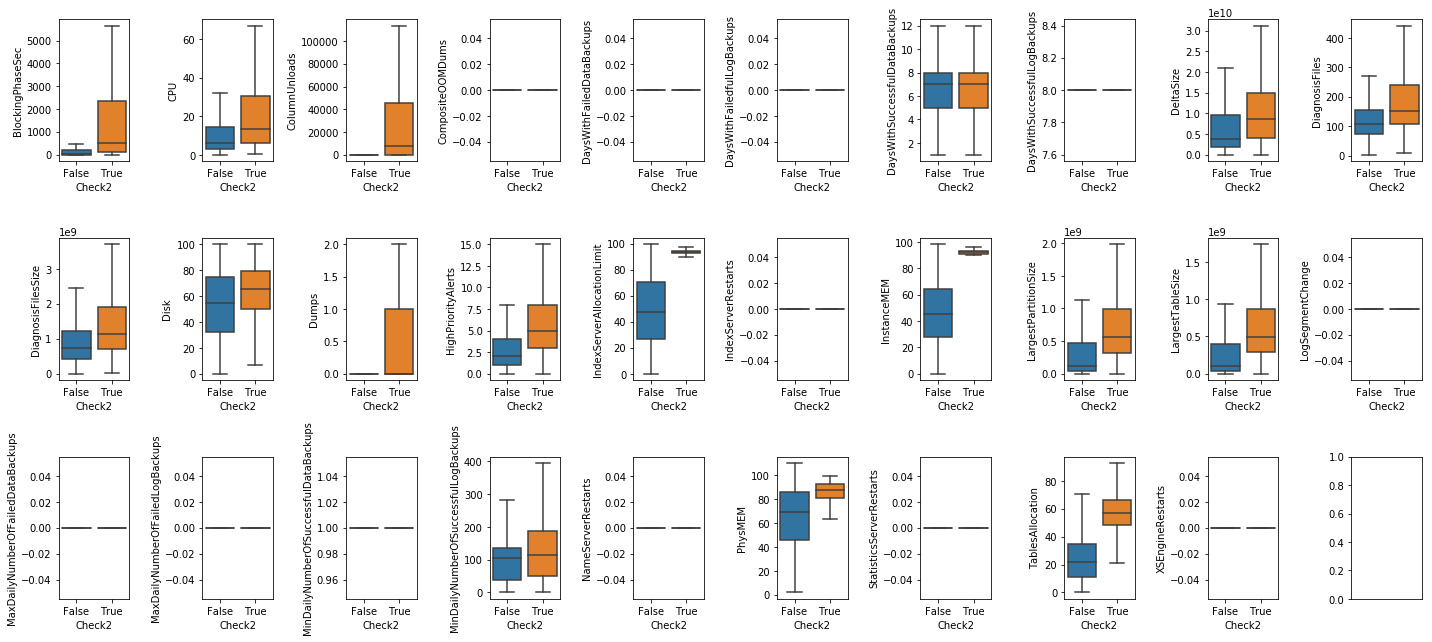

In [17]:
boxplot_numerical_features(datasets_before_prep[1], num_cols, "Check2", 3, 10, (20,9))

**COMMENT.**

There are many informative features for classifying label 2 such as _BlockingPhaseSec_, _CPU_, _ColumnUnloads_, _DiagnosisFiles_, _IndexServerAllocationLimit_, _PhysMEM_, _TableAllocation_, etc but they cannot completely seperate classes.

**Numerical features and label _Check3_**

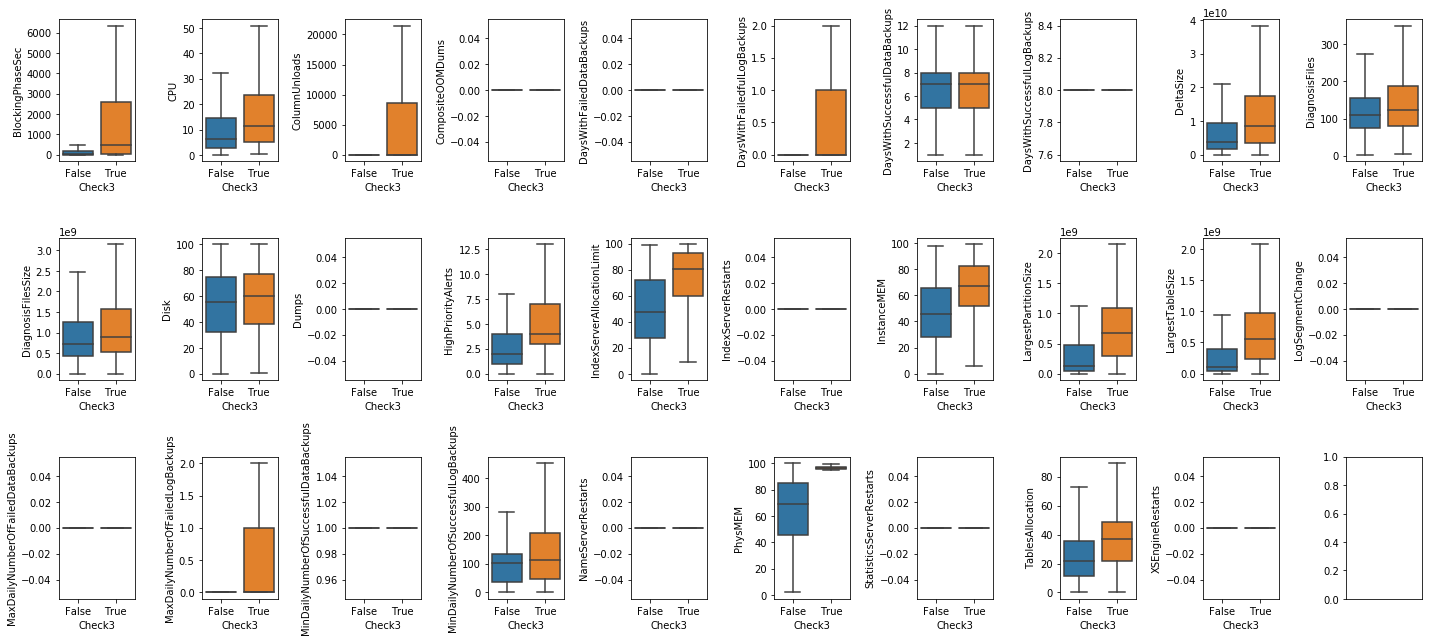

In [18]:
boxplot_numerical_features(datasets_before_prep[2], num_cols, "Check3", 3, 10, (20,9))

**COMMENT.**

Similar to the data for label 2, there are many informative features but cannot help to classify classes seperately. They are _BlockingPhaseSec_, _HighPriorityAlerts _, _ColumnUnloads_, _LargestTableSize_, _LargestPartitionSize_, etc.

**Numerical features and label _Check4_**

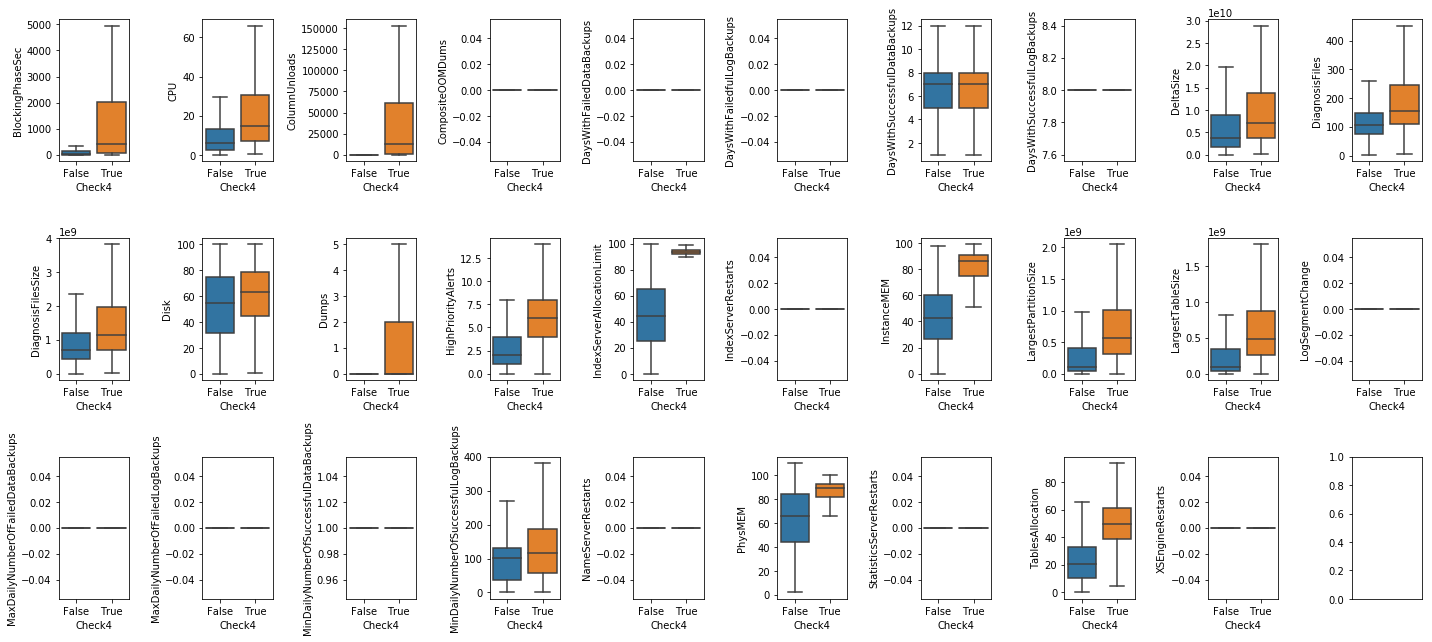

In [19]:
boxplot_numerical_features(datasets_before_prep[3], num_cols, "Check4", 3, 10, (20,9))

**COMMENT.**

For this label, the features which may be useful for classification are _BlockingPhaseSec_, _CPU_, _HighPriorityAlerts_, _ColumnUnloads_, _IndexServerAllocationLimit_, _InstanceMEM_, etc.

**Numerical features and label _Check5_**

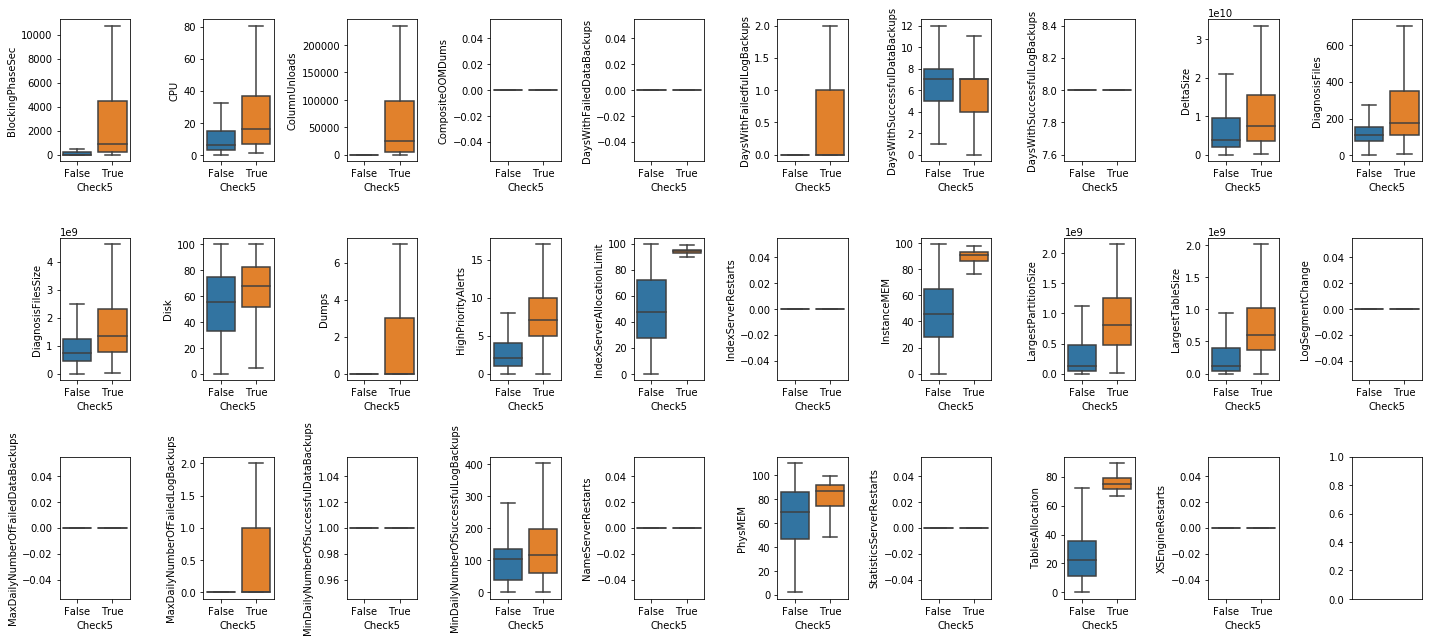

In [20]:
boxplot_numerical_features(datasets_before_prep[4], num_cols, "Check5", 3, 10, (20,9))

**COMMENT.**

As can be seen from this graph, _TableAllocation_ can be a very useful feature to specify anomaly in label 5. Besides that, _InstanceMEM_ is also a good feature.

**Numerical features and label _Check6_**

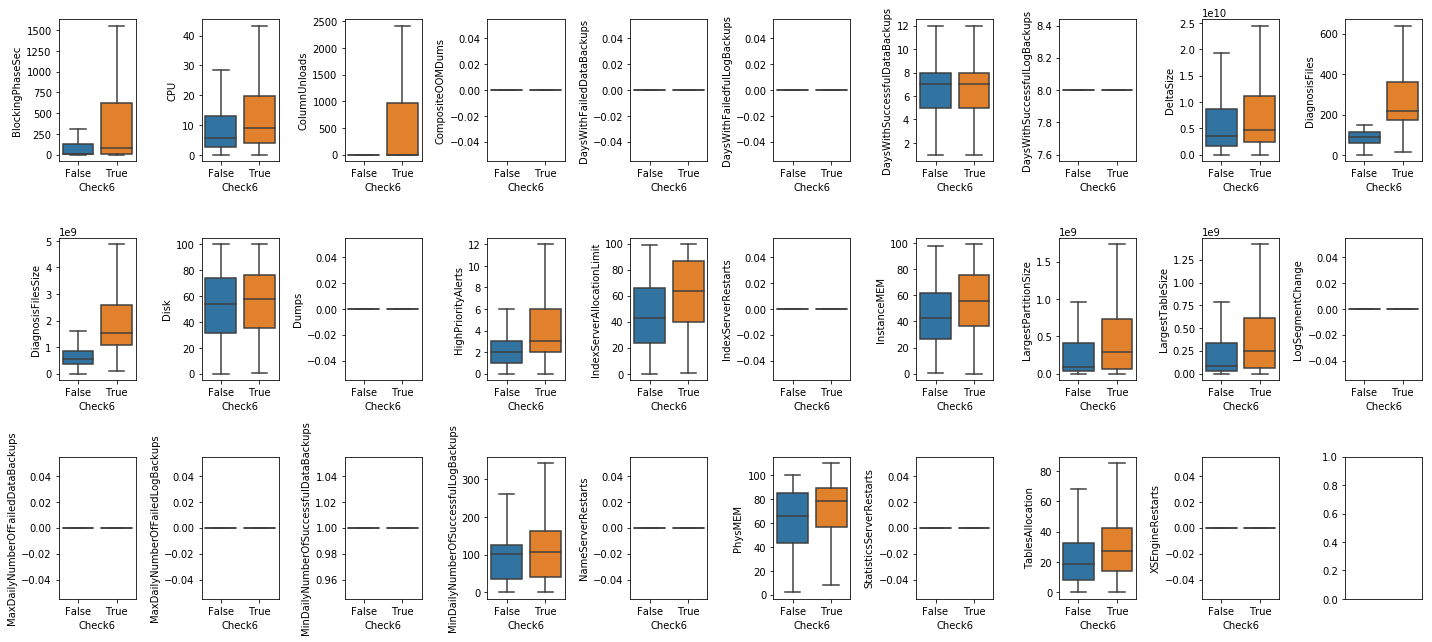

In [21]:
boxplot_numerical_features(datasets_before_prep[5], num_cols, "Check6", 3, 10, (20,9))

**COMMENT.**

For label 6, _DiagnosisFiles_ and _DiagnosisFilesSize_ are good features to classify the classes.

**Numerical features and label _Check7_**

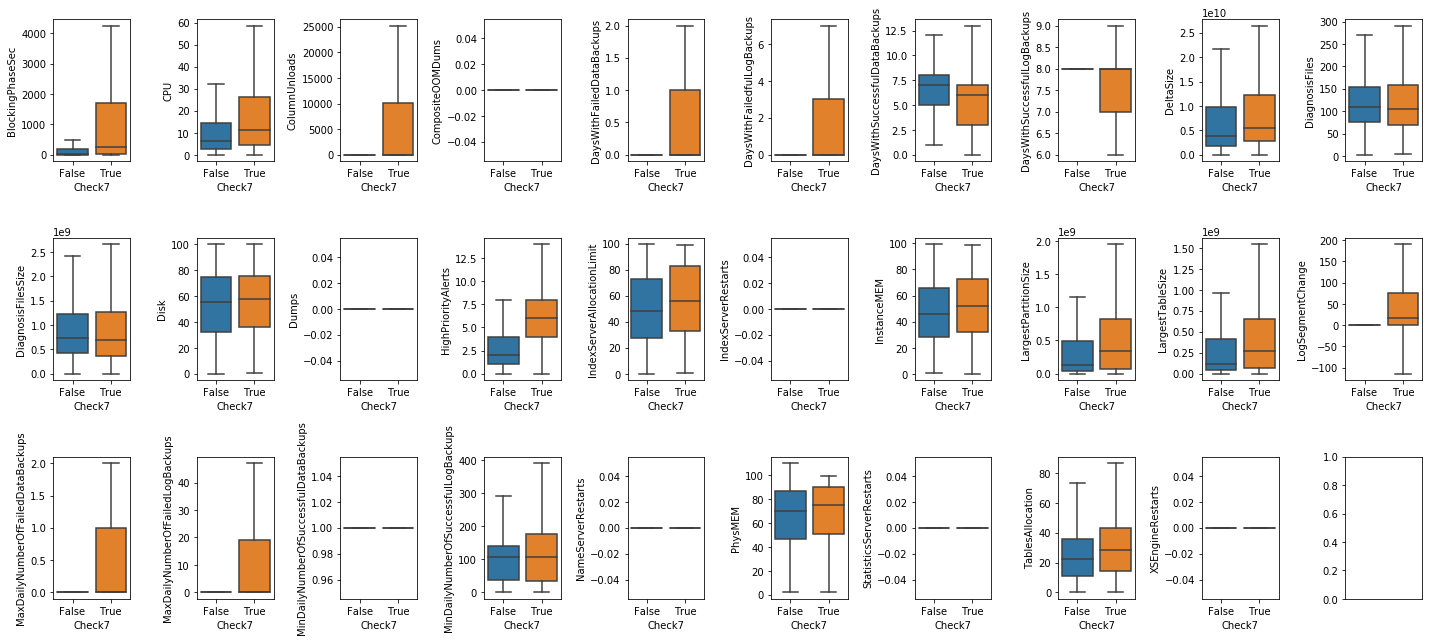

In [22]:
boxplot_numerical_features(datasets_before_prep[6], num_cols, "Check7", 3, 10, (20,9))

**COMMENT.**

For this label, _LogSegmentChange_ and _MaxDailyNumberOfFailedDataBackups_, _MaxDailyNumberOfFailedLogBackups_ are good features to classify the classes.

**Numerical features and label _Check8_**

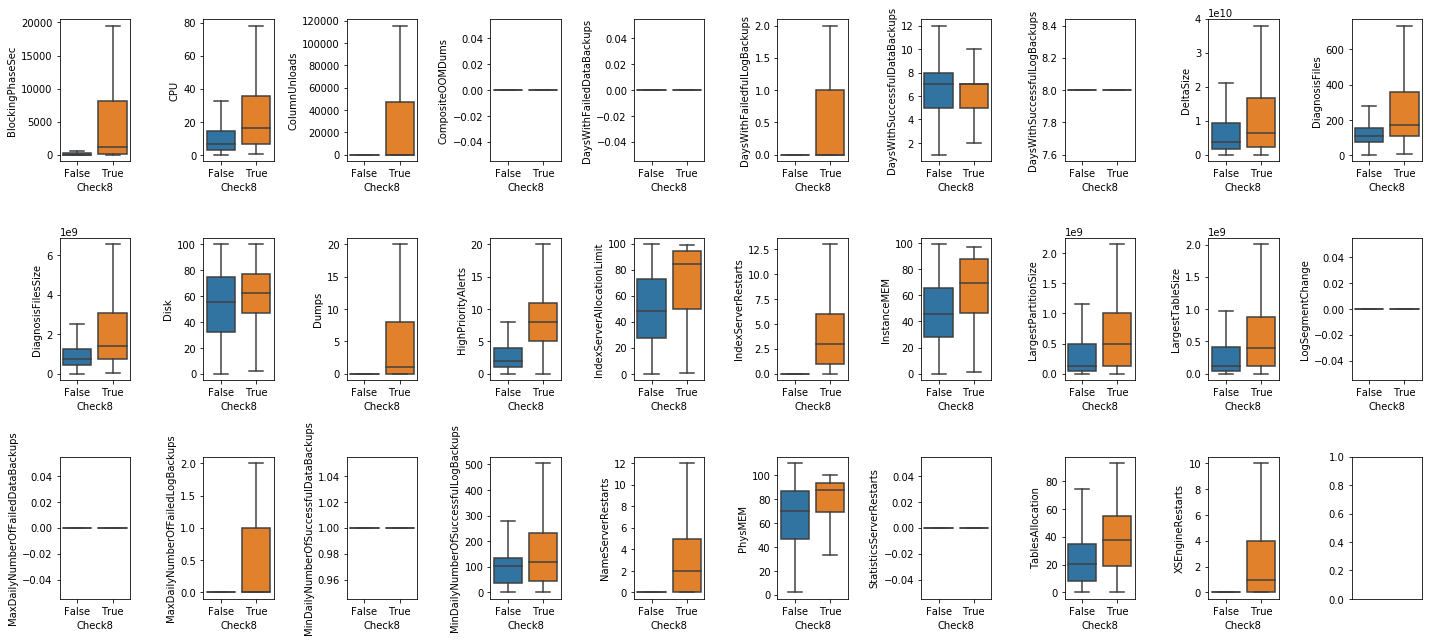

In [23]:
boxplot_numerical_features(datasets_before_prep[7], num_cols, "Check8", 3, 10, (20,9))

**COMMENT.**

For label 8, _NameServerRestarts_ and _XSEngineRestarts_ maybe the good features for classification.

---
## 2. DATA PREPARATION

Although not all algorithms fail when the data contain missing data/outliers/etc., there are algorithms which are not robust to unclean data. We create two sets of data for 8 models, one set is **not preprocessed** and another one is **preprocessed**.

### 2.1. Handle Errors/Missing information

- **Handling error values**

According to data description in the document, we prepared incorrect values of features _LogSegmentChange_, _CPU_, _PhysMEM_, _InstanceMEM_, _TablesAllocation_, _IndexServerAllocationLimit_, and _Disk_.
- We guess that there is a problem when recording data which caused the negative symbol. Therefore, we replace values of _LogSegmentChange_ by its absolute values to remove the negative values.
- We set the exceeded values of features _CPU_, _PhysMEM_, _InstanceMEM_, _TablesAllocation_, _IndexServerAllocationLimit_, _Disk_ to 100.

In [9]:
data['LogSegmentChange'] = abs(data['LogSegmentChange'])

In [10]:
features_range_0_100 = ['CPU','PhysMEM','InstanceMEM','TablesAllocation','IndexServerAllocationLimit','Disk']
for col in features_range_0_100:
    data.loc[data[col] >100, col] = 100

- **Handling missing information**

Since the number of missing values is quite big, we should be carefull before imputing them. To know whether the missing values are related to labels or not, we select the missing values of a feature and then compute its anomaly ratio.

In [26]:
# List of missing features
missing_cols = ['Dumps', 'CompositeOOMDums', 'CPU', 'PhysMEM', 'InstanceMEM', \
                'TablesAllocation', 'IndexServerAllocationLimit', 'DeltaSize', 'MergeErrors', 'BlockingPhaseSec', \
                'Disk', 'LargestTableSize', 'LargestPartitionSize', 'DiagnosisFiles', 'DiagnosisFilesSize', 'LogSegmentChange']

# List of ratio dataframes. ratio_all is a anomaly percent of whole data
ratio_labels_dfs = [ratio_all]

# Compute anomaly ratio of missing values of each feature, then add to the list
for col in missing_cols:
    ratio_df = ratio_labels(data[data[col].isna()==True], label_cols)
    ratio_labels_dfs.append(ratio_df)

# Concat mutiplt dataframes into one
ratio_labels_merged = pd.concat(ratio_labels_dfs, axis=1)
ratio_labels_merged.columns = ['AnomalyFullDataset'] + ['AnomalyMissing' + col for col in missing_cols]
ratio_labels_merged

,AnomalyFullDataset,AnomalyMissingDumps,AnomalyMissingCompositeOOMDums,AnomalyMissingCPU,AnomalyMissingPhysMEM,AnomalyMissingInstanceMEM,AnomalyMissingTablesAllocation,AnomalyMissingIndexServerAllocationLimit,AnomalyMissingDeltaSize,AnomalyMissingMergeErrors,AnomalyMissingBlockingPhaseSec,AnomalyMissingDisk,AnomalyMissingLargestTableSize,AnomalyMissingLargestPartitionSize,AnomalyMissingDiagnosisFiles,AnomalyMissingDiagnosisFilesSize,AnomalyMissingLogSegmentChange
Check1,"(260884, 1636, 0.01)","(3.0, nan, nan)","(3.0, nan, nan)","(2589.0, nan, nan)","(6.0, nan, nan)","(490.0, nan, nan)","(1713.0, 10.0, 0.01)","(5298.0, 35.0, 0.01)","(102.0, 1.0, 0.01)",NaN,"(52218, 298, 0.01)","(3667, 15, 0.0)","(13202, 59, 0.0)","(101.0, 1.0, 0.01)","(13112, 28, 0.0)","(13112, 28, 0.0)","(13648, 58, 0.0)"
Check2,"(253781, 8764, 0.03)","(2.0, 1.0, 0.33)","(2.0, 1.0, 0.33)","(3322.0, 44.0, 0.01)","(3.0, 1.0, 0.25)","(3.0, 1.0, 0.25)","(1646.0, 102.0, 0.06)","(5167.0, 176.0, 0.03)","(98.0, 3.0, 0.03)",NaN,"(50746, 2183, 0.04)","(3613, 66, 0.02)","(12700, 610, 0.05)","(98.0, 3.0, 0.03)","(12802, 351, 0.03)","(12802, 351, 0.03)","(12876, 618, 0.05)"
Check3,"(256370, 8093, 0.03)","(3.0, nan, nan)","(3.0, nan, nan)","(4318.0, 214.0, 0.05)","(5.0, 1.0, 0.17)","(1476.0, 40.0, 0.03)","(1682.0, 113.0, 0.06)","(5195.0, 221.0, 0.04)","(101.0, 2.0, 0.02)",NaN,"(53075, 1384, 0.03)","(3612, 118, 0.03)","(13132, 457, 0.03)","(100.0, 2.0, 0.02)","(12218, 1021, 0.08)","(12218, 1021, 0.08)","(14498, 490, 0.03)"
Check4,"(225569, 24815, 0.1)","(2.0, nan, nan)","(2.0, nan, nan)","(3896.0, 205.0, 0.05)","(12.0, 1.0, 0.08)","(1184.0, 194.0, 0.14)","(nan, nan, nan)","(2.0, nan, nan)","(72.0, 21.0, 0.23)",NaN,"(41795, 5438, 0.12)","(2998, 241, 0.07)","(9765, 1372, 0.12)","(73.0, 21.0, 0.22)","(3393, 1034, 0.23)","(3393, 1034, 0.23)","(10993, 1530, 0.12)"
Check5,"(248917, 3080, 0.01)","(2.0, nan, nan)","(2.0, nan, nan)","(4094.0, 24.0, 0.01)","(13.0, nan, nan)","(1329.0, 49.0, 0.04)","(1716.0, 12.0, 0.01)","(1844.0, 12.0, 0.01)","(78.0, nan, nan)",NaN,"(48143, 889, 0.02)","(3364, 22, 0.01)","(12686, 163, 0.01)","(84.0, nan, nan)","(4644, 148, 0.03)","(4644, 148, 0.03)","(13981, 227, 0.02)"
Check6,"(199075, 80572, 0.29)","(2.0, 1.0, 0.33)","(2.0, 1.0, 0.33)","(11975.0, 5972.0, 0.33)","(8114.0, 5193.0, 0.39)","(9250.0, 5605.0, 0.38)","(949.0, 1247.0, 0.57)","(12482.0, 6616.0, 0.35)","(86.0, 79.0, 0.48)",NaN,"(45112, 23403, 0.34)","(2704, 1343, 0.33)","(9012, 5910, 0.4)","(69.0, 40.0, 0.37)","(7159, 7425, 0.51)","(7159, 7425, 0.51)","(17641, 10636, 0.38)"
Check7,"(243621, 7688, 0.03)","(3.0, nan, nan)","(3.0, nan, nan)","(3259.0, 178.0, 0.05)","(124.0, nan, nan)","(140.0, 1.0, 0.01)","(nan, nan, nan)","(3998.0, 115.0, 0.03)","(42.0, nan, nan)",NaN,"(39520, 1014, 0.03)","(3391, 201, 0.06)","(175, 8, 0.04)","(37.0, nan, nan)","(11469, 667, 0.05)","(11469, 667, 0.05)","(31, 3, 0.09)"
Check8,"(284060, 2919, 0.01)","(3.0, nan, nan)","(3.0, nan, nan)","(25139.0, 57.0, 0.0)","(20554.0, nan, nan)","(22068.0, 36.0, 0.0)","(2144.0, 146.0, 0.06)","(26255.0, 174.0, 0.01)","(205.0, 1.0, 0.0)",NaN,"(74901, 930, 0.01)","(11311, 58, 0.01)","(15960, 288, 0.02)","(140.0, 10.0, 0.07)","(21489, 419, 0.02)","(21489, 419, 0.02)","(35220, 314, 0.01)"


We compare the percent of anomaly of missing features to the percent of whole data. As can be seen from the table, there are several remarkable points:
- For label _Check6_, the percent of anomaly of whole data is **29%** while the anomaly percent where missing TableAllocation, PhysMEM, InstanceMEM and IndexServerAllocationLimit are **57%**, **39%**, **38%** and **35%**, respectively.
- For label _Check3_, the percent of anomaly of whole data is **3%** while the anomaly percent where missing CPU, TableAllocation are **5%**, **6%**, respectively.
- etc.

We are not sure about the reasons of missing values, therefore, we will not impute them. We prefer to train models on lack of information data than to train models on incorrect information data. Therefore, in the preprocessed data, we drop missing rows instead of filling them.

In [11]:
# Get dataset for each label
datasets_after_prep = []
for i in range(1, 9):
    df = get_data_by_label(data, 'Check%d'%i)
    datasets_after_prep.append(df)
    
# Removing missing rows for each dataset
for df in datasets_after_prep:
    df.dropna(inplace=True)

### 2.2. Standardization, Normalization, Outliers

**Standardization/Normalization**

According to the data exploration, there are very informative features for each model. For interpretation purpose, we intent to use tree-based and rule-based algorithms for learning models. These algorithms utilize rules and do not require normalization/standardization. They would not be affected by any monotonic transformations of the variables.

**Outliers**

We keep the outliers while preprocessing data because of two reasons:
- First, we think that outliers can be related to anomalies. 
- Second, we intent to use rule learning models and tree-based models which are robust to outliers.

### 2.3. Train/Test Split

Here we split data into train set and test set with the ratio as 7:3.

In [12]:
test_size = 0.3
random_state = 42

# Split train/test data which are not preprocessed
traintest_before_prep = []
for df in datasets_before_prep:
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    traintest_before_prep.append((X_train, X_test, y_train, y_test))

# Split train/test data which are preprocessed
traintest_after_prep = []
for df in datasets_after_prep:
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    traintest_after_prep.append((X_train, X_test, y_train, y_test))

### 2.5. Mutual Information

After preprocessing data, we can measure the Mutual Information of categorical features and labels. To know how good these mutual-information are, we compare them to the entropy of the targets.

In [13]:
# A function to compute mutual information and percent of reduce of uncertainty
def features_reduce_uncertainty(features, target, percent_reducing):
    """ Compute mutual information and percent of reduce of uncertainty
    Parameters:
        features (DataFrame): A dataframe which contains only categorical features
        target (Series/Numpy array): The target column
        percent_reducing (float): The percent of reduce of uncertainty
    
    Return:
        A dataframe with top mutual information according to the given percent of reduce of uncertainty    
    """
    # Compute mutual information between categorical features and labels
    mutual_info = mutual_info_classif(features, target)
    mutual_info_df = pd.DataFrame(data=mutual_info, index=features.columns, columns=['MI'])
    # Sort the dataframe by the mutual information
    mutual_info_df.sort_values(by='MI', inplace=True, ascending=False)
    
    # Compute entropy of the target
    target_entropy = entropy(target.value_counts().tolist())
    
    # Compute number of features which can reduce the uncertainty of the target
    ncols_reducing = len(mutual_info_df[mutual_info_df['MI'] > percent_reducing*target_entropy])
    
    print('Entropy of the target: %.2f' % (target_entropy))
    print("# of features that reduces uncertainty BY-MORE-THAN-{}%: {}.".format(percent_reducing*100, ncols_reducing))
    return mutual_info_df[:ncols_reducing].T

In [14]:
# Top Mutual Information for model 1
topMI_check1 = features_reduce_uncertainty(traintest_after_prep[0][0], traintest_after_prep[0][2], 0.1)
display(topMI_check1)

Entropy of the target: 0.04
# of features that reduces uncertainty BY-MORE-THAN-10.0%: 11.


,CPU,MinDailyNumberOfSuccessfulDataBackups,DaysWithSuccessfulLogBackups,SystemID,HighPriorityAlerts,LargestTableSize,LargestPartitionSize,DaysWithSuccessfulDataBackups,MergeErrors,Disk,BlockingPhaseSec
MI,0.040596,0.02956,0.019726,0.00864,0.007946,0.006681,0.006627,0.006087,0.005597,0.005059,0.004205


In [15]:
# Top Mutual Information for model 2
topMI_check2 = features_reduce_uncertainty(traintest_after_prep[1][0], traintest_after_prep[1][2], 0.1)
display(topMI_check2)

Entropy of the target: 0.14
# of features that reduces uncertainty BY-MORE-THAN-10.0%: 13.


,InstanceMEM,IndexServerAllocationLimit,TablesAllocation,SystemID,LargestPartitionSize,LargestTableSize,ColumnUnloads,MinDailyNumberOfSuccessfulDataBackups,Disk,BlockingPhaseSec,HighPriorityAlerts,DaysWithSuccessfulLogBackups,PhysMEM
MI,0.14132,0.0833,0.058183,0.040565,0.040042,0.038822,0.035798,0.028193,0.025647,0.020571,0.019779,0.019659,0.019603


In [16]:
# Top Mutual Information for model 3
topMI_check3 = features_reduce_uncertainty(traintest_after_prep[2][0], traintest_after_prep[2][2], 0.1)
display(topMI_check3)

Entropy of the target: 0.13
# of features that reduces uncertainty BY-MORE-THAN-10.0%: 10.


,PhysMEM,LargestPartitionSize,SystemID,LargestTableSize,MinDailyNumberOfSuccessfulDataBackups,Disk,DaysWithSuccessfulLogBackups,IndexServerAllocationLimit,InstanceMEM,BlockingPhaseSec
MI,0.132596,0.041361,0.040273,0.036845,0.028574,0.027351,0.020231,0.017152,0.014456,0.014378


In [17]:
# Top Mutual Information for model 4
topMI_check4 = features_reduce_uncertainty(traintest_after_prep[3][0], traintest_after_prep[3][2], 0.1)
display(topMI_check4)

Entropy of the target: 0.31
# of features that reduces uncertainty BY-MORE-THAN-10.0%: 12.


,IndexServerAllocationLimit,InstanceMEM,ColumnUnloads,TablesAllocation,LargestPartitionSize,LargestTableSize,SystemID,HighPriorityAlerts,PhysMEM,BlockingPhaseSec,Disk,CPU
MI,0.312355,0.148203,0.125092,0.107072,0.092476,0.088515,0.075307,0.06297,0.059098,0.055744,0.041938,0.032994


In [18]:
# Top Mutual Information for model 5
topMI_check5 = features_reduce_uncertainty(traintest_after_prep[4][0], traintest_after_prep[4][2], 0.1)
display(topMI_check5)

Entropy of the target: 0.06
# of features that reduces uncertainty BY-MORE-THAN-10.0%: 15.


,TablesAllocation,MinDailyNumberOfSuccessfulDataBackups,InstanceMEM,IndexServerAllocationLimit,SystemID,DaysWithSuccessfulLogBackups,LargestPartitionSize,LargestTableSize,ColumnUnloads,HighPriorityAlerts,Disk,BlockingPhaseSec,PhysMEM,DaysWithSuccessfulDataBackups,MergeErrors
MI,0.057247,0.029313,0.025791,0.025609,0.021464,0.020981,0.020314,0.018859,0.018207,0.013662,0.012663,0.009531,0.007101,0.006095,0.005989


In [19]:
# Top Mutual Information for model 6
topMI_check6 = features_reduce_uncertainty(traintest_after_prep[5][0], traintest_after_prep[5][2], 0.1)
display(topMI_check6)

Entropy of the target: 0.57
# of features that reduces uncertainty BY-MORE-THAN-10.0%: 6.


,DiagnosisFiles,DiagnosisFilesSize,LargestPartitionSize,LargestTableSize,SystemID,Disk
MI,0.561626,0.228105,0.200619,0.191763,0.156583,0.072528


In [20]:
# Top Mutual Information for model 7
topMI_check7 = features_reduce_uncertainty(traintest_after_prep[6][0], traintest_after_prep[6][2], 0.1)
display(topMI_check7)

Entropy of the target: 0.13
# of features that reduces uncertainty BY-MORE-THAN-10.0%: 7.


,LogSegmentChange,MinDailyNumberOfSuccessfulDataBackups,DaysWithSuccessfulLogBackups,HighPriorityAlerts,LargestPartitionSize,LargestTableSize,SystemID
MI,0.073485,0.02689,0.023993,0.022182,0.017315,0.016898,0.013564


In [21]:
# Top Mutual Information for model 8
topMI_check8 = features_reduce_uncertainty(traintest_after_prep[7][0], traintest_after_prep[7][2], 0.1)
display(topMI_check8)

Entropy of the target: 0.05
# of features that reduces uncertainty BY-MORE-THAN-10.0%: 18.


,IndexServerRestarts,MinDailyNumberOfSuccessfulDataBackups,NameServerRestarts,DaysWithSuccessfulLogBackups,XSEngineRestarts,HighPriorityAlerts,LargestPartitionSize,LargestTableSize,SystemID,BlockingPhaseSec,Disk,Dumps,IndexServerAllocationLimit,DaysWithSuccessfulDataBackups,TablesAllocation,MergeErrors,InstanceMEM,PhysMEM
MI,0.03178,0.028732,0.024861,0.02137,0.020687,0.014892,0.012983,0.012362,0.010785,0.007989,0.007343,0.006681,0.00648,0.005949,0.005675,0.00563,0.005615,0.005606


**COMMENT.**

Although we plot boxplot to examine the relationship between categorical features and labels, we employ Mutual Information between them and select the best features which help to reduce the uncertainty in the labels. The selected features will be use in the Model Selection (Section 3.).

---
## 3. MODEL SELECTION

In [11]:
# A function to train, predict and measure running time
def evaluate(X_train, X_test, y_train, y_test, model):
    """ A function to train, predict and measure running time
        Parameters:
            X_train (DataFrame): Features for training
            X_test (DataFrame): Features for predicting
            y_train (Array): Target for training
            y_test: True target for testing
            model: Model for learning
        Returns:
            y_pred (Array): The prediction
            f1 (float): F1 macro score
            fitting_time (float): Duration for training
    """
    # Fit the training data
    start = time.time()
    model = model
    model.fit(X_train, y_train)
    fitting_time = time.time()-start

    # Predict the testing data
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Print f1 score and the training time
    print('\033[1m' + 'F1 \'macro\': %.4f \t Fitting time: %.4f' % (f1, fitting_time) + '\033[0m')
    
    return y_pred, f1, fitting_time


# A cross-validate function 
def cross_validate_KFold(X, y, nfolds, random_state , model):
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

    traintest = []

    kf = KFold(n_splits=nfolds, shuffle=True, random_state=random_state)
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.ix[train_idx], X.ix[test_idx]
        y_train, y_test = y.ix[train_idx], y.ix[test_idx]
        traintest.append((X_train, X_test, y_train, y_test))
    
    scores = []
    for tupl in traintest:
        _, f1, fitting_time = evaluate(tupl[0], tupl[1], tupl[2].as_matrix(), tupl[3].as_matrix(), model)
        scores.append(np.array([f1, fitting_time]))
    result = np.round(np.array(scores).mean(axis=0), decimals=3)
    print('\033[1m' + '\nAvg F1 macro and Avg fitting time: %s' %  result + '\033[0m' )
    
    return result

**SUBSET DATA**

Although 8 models are 8 different anomalies, its features are similar. Therefore, we implement model selection for only one label and then apply to the others. To save time, we train the models on a subset data instead of whole data. The large data will be used in the the evaluation section (Section 5).

Here we have 4 datasets for label _Check1_:
- The dataset which is not preprocessed, with full features.
- The dataset which is not preprocessed, with selected features based on the mutual information.
- The dataset which is preprocessed, with full features.
- The dataset which is preprocessed, with selected features based on the mutual information.

In [12]:
# Full features which are not preprocessed
X1_train = traintest_before_prep[0][0]
# Selected features which are not preprocessed
X1_train_FS = traintest_before_prep[0][0][topMI_check1.columns]
# Target corresponding to features not preprocessed
y1_train = traintest_before_prep[0][2]

# Full features which are preprocessed
X2_train = traintest_after_prep[0][0]
# Selected features which are preprocessed
X2_train_FS = traintest_after_prep[0][0][topMI_check1.columns]
# Target corresponding to preprocessed features
y2_train = traintest_after_prep[0][2]

**ALGORITHMS**

Here we will train the model 1 (label _Check1_) using a **rule-learning algorithm (Bayesian Rule Set)** and a **tree-based algorithm (Decision Tree)**.

**1. Complexity**
- _Bayesian Rule Set_:  Finding sparse models is computationally hard, Bayesian Rule Set tries to find the **globally optimal solution** in the reduced space of rules. Its complexity depends on total number of conditions in the model, which is the sum of lengths for all rules.
- _Decision Tree_: The model is to find the **locally optimal solution**. Its complexity **O(n<sub>samples</sub>*n<sub>features</sub>*log(n<sub>samples</sub>))**. However, Scikit-learn offers a more efficient implementation for the construction of decision trees. Presorting the feature over all relevant samples, and retaining a running label count, will reduce the complexity at each node, which results in a total cost.

**2. Interpretation**
- _Bayesian Rule Set_:  This model has the advantage of being interpretable to human experts since they produce a set of rules that concisely describe a speciﬁc class, as long as it uses fewer rules. However, when using fewer rules, it can lose information. Rules with a constraint on the maximum length tend to be less accurate when dealing with high dimensional feature spaces.
- _Decision Tree_: Decision trees are very interpretable, as long as they are short. The number of terminal nodes increases quickly with depth. The more terminal nodes and the deeper the tree, the more difficult it becomes to understand the decision rules of a tree.

**3. Handling imbalanced datasets**

Imbalanced dataset is a very frequent problem in classification, not just in _Bayesian Rule Set_ and _Decision Tree_ but in virtually all classification algorithms. The prediction will be biased towards the more frequent class.

**4. Handling both numerical and categorical**

_Bayesian Rule Set_ and _Decision Tree_ can handle both numerical and categorical variables.

**5. Handling missing values**
- _Bayesian Rule Set_: This form of models are generally robust to outliers and naturally handle missing data, with no imputation needed for missing attribute values.
- _Decision Tree_: Tree-based methods can use the missing value as a unique and different value when building the predictive model. These algorithms are also robust to outliers. Sadly, the scikit-learn implementations of decision trees is not robust to missing values.

### 3.1. Bayesian Rule Set

Here we train the subset data using Bayesian Rule Set. 

The Bayesian Rule Set consists of a set of rules, where each rule is a conjunction of conditions. Rule set models predict that an observation is in the positive class when at least one of the rules is satisﬁed. Otherwise, the observation is classified to be in the negative class.

In [40]:
brs = BayesianRuleSet(method='forest')

_, X_subset, _, y_subset = train_test_split(X1_train, y1_train, test_size=0.1, random_state=2019)
_ = cross_validate_KFold(X_subset, y_subset, 3, 42, brs)


** chain = 1, max at iter = 0 ** 
 accuracy = 0.9939596767610808, TP = 0,FP = 0, TN = 12177, FN = 74
 old is -999999999.9, pt_new is -482.04892117013037, prior_ChsRules=-27.840213445946574, likelihood_1 = 0.0, likelihood_2 = -454.2087077241838
 
[]
F1 'macro': 0.4980 	 Fitting time: 174.6350

** chain = 1, max at iter = 0 ** 
 accuracy = 0.9977960982776917, TP = 58,FP = 5, TN = 12166, FN = 22
 old is -999999999.9, pt_new is -212.39690231206157, prior_ChsRules=-27.84038912411779, likelihood_1 = -21.076762022734442, likelihood_2 = -163.47975116520934
 
['90.2<=CPU', '3.0<=BlockingPhaseSec', 'InstanceMEM<89.77', '33.72<=InstanceMEM', 'CPU<4602.49']
[441]

** chain = 1, max at iter = 3 ** 
 accuracy = 0.9987756101542731, TP = 70,FP = 5, TN = 12166, FN = 10
 old is -212.29690231206158, pt_new is -187.0254802827851, prior_ChsRules=-81.66070162411779, likelihood_1 = -21.509427409232103, likelihood_2 = -83.85535124943522
 
['90.2<=CPU', '3.0<=BlockingPhaseSec', 'InstanceMEM<89.77', '33.72<=In

In [41]:
_, X_subset, _, y_subset = train_test_split(X1_train_FS, y1_train, test_size=0.1, random_state=2019)
_ = cross_validate_KFold(X_subset, y_subset, 3, 42, brs)


** chain = 1, max at iter = 0 ** 
 accuracy = 0.9879193535221614, TP = 1,FP = 75, TN = 12102, FN = 73
 old is -999999999.9, pt_new is -593.7498138754074, prior_ChsRules=-27.835748614743352, likelihood_1 = -117.27488919050256, likelihood_2 = -448.6391760701615
 
['CPU<99.99', '100.0<=Disk', 'SystemID_654_neg']
[600]

** chain = 1, max at iter = 8 ** 
 accuracy = 0.9923271569667782, TP = 1,FP = 21, TN = 12156, FN = 73
 old is -593.6498138754074, pt_new is -530.4882329859686, prior_ChsRules=-27.835748614743352, likelihood_1 = -53.6875149315797, likelihood_2 = -448.96496943964553
 
['990452609.0<=LargestPartitionSize', 'LargestPartitionSize<1707313990.0', 'SystemID_723_neg', 'SystemID_73']
[10]

** chain = 1, max at iter = 22 ** 
 accuracy = 0.9939596767610808, TP = 0,FP = 0, TN = 12177, FN = 74
 old is -530.3882329859686, pt_new is -482.04445633892715, prior_ChsRules=-27.835748614743352, likelihood_1 = 0.0, likelihood_2 = -454.2087077241838
 
[]

** chain = 1, max at iter = 71 ** 
 accur

In [42]:
_, X_subset, _, y_subset = train_test_split(X2_train, y2_train, test_size=0.1, random_state=2019)
_ = cross_validate_KFold(X_subset, y_subset, 3, 42, brs)


** chain = 1, max at iter = 0 ** 
 accuracy = 0.992435869326902, TP = 0,FP = 0, TN = 9053, FN = 69
 old is -999999999.9, pt_new is -435.82344999233715, prior_ChsRules=-27.827397733926773, likelihood_1 = 0.0, likelihood_2 = -407.9960522584104
 
[]
F1 'macro': 0.4986 	 Fitting time: 131.3369

** chain = 1, max at iter = 0 ** 
 accuracy = 0.9934232160473528, TP = 0,FP = 0, TN = 9063, FN = 60
 old is -999999999.9, pt_new is -391.29632373117306, prior_ChsRules=-27.831725384108722, likelihood_1 = 0.0, likelihood_2 = -363.46459834706434
 
[]

** chain = 1, max at iter = 56 ** 
 accuracy = 0.9934232160473528, TP = 0,FP = 0, TN = 9063, FN = 60
 old is -391.19632373117304, pt_new is -384.06633754037716, prior_ChsRules=-20.601739193312824, likelihood_1 = 0.0, likelihood_2 = -363.46459834706434
 
[]
F1 'macro': 0.4981 	 Fitting time: 134.2788

** chain = 1, max at iter = 0 ** 
 accuracy = 0.8178230845116737, TP = 0,FP = 1601, TN = 7461, FN = 61
 old is -999999999.9, pt_new is -754.3993265368949, 

In [43]:
_, X_subset, _, y_subset = train_test_split(X2_train_FS, y2_train, test_size=0.1, random_state=2019)
_ = cross_validate_KFold(X_subset, y_subset, 3, 42, brs)


** chain = 1, max at iter = 0 ** 
 accuracy = 0.916794562595922, TP = 13,FP = 703, TN = 8350, FN = 56
 old is -999999999.9, pt_new is -684.3211369622636, prior_ChsRules=-20.596354813314974, likelihood_1 = -325.1047552384505, likelihood_2 = -338.62002691049815
 
['CPU<99.35', '905039812.0<=LargestTableSize', 'LargestTableSize<1611004147.0']
[1834]

** chain = 1, max at iter = 3 ** 
 accuracy = 0.9913396185047139, TP = 1,FP = 11, TN = 9042, FN = 68
 old is -684.2211369622636, pt_new is -457.518451745796, prior_ChsRules=-20.596354813314974, likelihood_1 = -33.90395201211936, likelihood_2 = -403.0181449203617
 
['977870690.0<=LargestPartitionSize', 'LargestPartitionSize<1611004147.0', 'SystemID_73']
[1200]

** chain = 1, max at iter = 14 ** 
 accuracy = 0.992435869326902, TP = 0,FP = 0, TN = 9053, FN = 69
 old is -457.418451745796, pt_new is -435.8190534950652, prior_ChsRules=-27.823001236654818, likelihood_1 = 0.0, likelihood_2 = -407.9960522584104
 
[]

** chain = 1, max at iter = 194 *

**COMMENT.**

**A. Cross-validation results**

|      Subset data                         |  CV=3| F1 'macro'  |Training time  |
| -----------------------------------------|------| ----------- |---------------|
| Full features, not preprocessed data     |  #1  | 0.4980      | 174.6350      |
| Full features, not preprocessed data     |  #2  | 0.9678      | 178.1014      |
| Full features, not preprocessed data     |  #3  | 0.9736      | 187.4181      |
| Full features, not preprocessed data     |<b>Avg</b>|<b>0.813</b>|<b>180.052</b>|
| -----------------------------------------|------|-------------|---------------|
| Selected features, not preprocessed data |  #1  | 0.4980      | 103.3495      |
| Selected features, not preprocessed data |  #2  | 0.9678      | 110.5208      |
| Selected features, not preprocessed data |  #3  | 0.9915      | 116.4722      |
| Selected features, not preprocessed data |<b>Avg</b>|<b>0.819</b>|<b>110.114</b>|
| -----------------------------------------|------|-------------|---------------|
| Full features,     preprocessed data     |  #1  | 0.4986      | 131.3369      |
| Full features,     preprocessed data     |  #2  | 0.4981      | 134.2788      |
| Full features,     preprocessed data     |  #3  | 0.4981      | 133.1967      |
| Full features,     preprocessed data     |<b>Avg</b>|<b>0.498</b>|<b>132.938</b>|
| -----------------------------------------|------|-------------|---------------|
| Selected features,     preprocessed data |  #1  | 0.4985      | 76.5023       |
| Selected features,     preprocessed data |  #2  | 0.4981      | 79.0241       |
| Selected features,     preprocessed data |  #3  | 0.4981      | 67.2948       |
| Selected features,     preprocessed data |<b>Avg</b>|<b>0.498</b>|<b>74.274</b>|
| -----------------------------------------|------|-------------|---------------|

**B. REMARK**

The cross-validation outputs for model of Label _Check1_ shows that:

1. Bayesian Rule Set model works better on the raw data (f1 macro **~0.81**) than on the preprocessed data (f1 macro **~0.49**). This experiment is suitable with the information of algorithms mentioned before (_"robust to outliers and naturally handle missing data, with no imputation needed for missing attribute values"_).

2. The selected features using Mutual Information are really useful for Bayesian Rule Set model. They help to reduce a lot of the training time while preserving the f1 score. The training time when using full features (31 features) is **~180 seconds** while the time when training on selected features (11 features) is **~110 seconds**. It reduces **~40%** of time.

3. The predictive performances of Bayesian Rule Set are not stable on different datasets. For example, using the not-preprocessed data, _f1 'macro'_ at CV-#1 data is **~0.49** while it at CV-#2 data and CV-#3 data are **0.97** and **0.97**, respectively.

4. Compared to Decision Tree model in Section 3.2., Bayesian Rule Set model runs slower and its performance is lower.

5. About the rules of the model:
    - We do cross-validation with 3 folds using two datasets and with two set of features. Let's take a look to one of these results. Considering the CV-#2, the output rules is ['90.2<=CPU', 'CPU<4602.49', 'SystemID_238_neg']. That means each instance which satifies at least one of these three conditions {CPU usage equal or more than 90.2; CPU usage less than 4602.49; SystemID is '238'} will be classified as Anomaly. Otherwise, it will be classified as non-Anomaly.

    - In general, training the model on cross-validation sets of the subsets, the number of rules are from 3 to 5. On average, it is 3 rules.

### 3.2. DecisionTreeClassifier

Decision Trees Classifier is a non-parametric supervised learning method. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

In [44]:
dtc = DecisionTreeClassifier(random_state=0)

_, X_subset, _, y_subset = train_test_split(X2_train, y2_train, test_size=0.1, random_state=2019)
_ = cross_validate_KFold(X_subset, y_subset, 3, 42, dtc)

F1 'macro': 0.9901 	 Fitting time: 0.0394
F1 'macro': 1.0000 	 Fitting time: 0.0406
F1 'macro': 0.9856 	 Fitting time: 0.0402

Avg F1 macro and Avg fitting time: [0.992 0.04 ]


In [45]:
_, X_subset, _, y_subset = train_test_split(X2_train_FS, y2_train, test_size=0.1, random_state=2019)
_ = cross_validate_KFold(X_subset, y_subset, 3, 42, dtc)

F1 'macro': 0.9692 	 Fitting time: 0.0152
F1 'macro': 1.0000 	 Fitting time: 0.0197
F1 'macro': 0.9856 	 Fitting time: 0.0202

Avg F1 macro and Avg fitting time: [0.985 0.018]


**A. Cross-validation results**

|      Subset data                         |  CV=3| F1 'macro'  |Training time  |
| -----------------------------------------|------| ----------- |---------------|
| Full features,     preprocessed data     |  #1  | 0.9901      | 0.0394        |
| Full features,     preprocessed data     |  #2  | 1.0000      | 0.0406        |
| Full features,     preprocessed data     |  #3  | 0.9856      | 0.0402        |
| Full features,     preprocessed data     |<b>Avg</b>|<b>0.992</b>|<b>0.04</b>|
| -----------------------------------------|------|-------------|---------------|
| Selected features,     preprocessed data |  #1  | 0.9692      | 0.0152        |
| Selected features,     preprocessed data |  #2  | 1.0000      | 0.0197        |
| Selected features,     preprocessed data |  #3  | 0.9856      | 0.0202        |
| Selected features,     preprocessed data |<b>Avg</b>|<b>0.985</b>|<b>0.018</b>|
| -----------------------------------------|------|-------------|---------------|


**B. REMARK**

The cross-validation outputs for model of Label _Check1_ shows that:

1. Although the datasets are extremely unbalanced, the preditive performances of Decision Tree model are very high (**~0.9 - 1.0**). That's because 
of the features on this data. There are super useful informative features for detecting anomalies. The minority class are all in one area of the feature space.

2. The selected features using Mutual Information are useful for the model (help to reduce the training time from 0.04 seconds to 0.18 seconds) but not very much. The reason is that the training time of Decision Tree model is so small, therefore, we cannot see the improvement clearly.

3. Compared to Bayesian Rule Set model in Section 3.1., Decision Tree model is **much better** in terms of accuracy and expecially in terms of training time. Decision Tree model loops through features and try to find the locally optimal solutions, therefore, it is faster than finding the global optimal solutions on full space of rules.

### IN SUMMARY

We will use the Decision Tree Classifier model and full features for detecting anomalies.

---
## 4. PARAMETER OPTIMISATION

Here we try to find the best hyperparmeter for each model (model from 1 to 8) using **GridSearchCV**. The parameters for optimizing are _max_depth_, _max_features_, _min_samples_leaf_ and _min_samples_split_.

In [19]:
parameters = {'max_depth': [3, 4, 5, 6, 7],
              'min_samples_split':[2, 3, 4, 5], 
             'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
             'max_features': [10, 15, 20, 25, 30]}

**OPTIMIZING FOR MODEL 1 (_Check1_)**

In [27]:
dtc = DecisionTreeClassifier(random_state=0)
grid = GridSearchCV(dtc, parameters, cv=3, scoring='f1_macro')
grid.fit(traintest_after_prep[0][0], traintest_after_prep[0][2])

print('Best score: ', grid.best_score_)
print('Best params: ', grid.best_params_)

Best score:  0.9962789078023412
Best params:  {'max_features': 25, 'min_samples_leaf': 5, 'min_samples_split': 2, 'max_depth': 4}


**OPTIMIZING FOR MODEL 2 (_Check2_)**

In [20]:
dtc = DecisionTreeClassifier(random_state=0)
grid = GridSearchCV(dtc, parameters, cv=3, scoring='f1_macro')
grid.fit(traintest_after_prep[1][0], traintest_after_prep[1][2])
print('Best score: ', grid.best_score_)
print('Best params: ', grid.best_params_)

Best score:  0.9984826419590069
Best params:  {'max_features': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'max_depth': 6}


**OPTIMIZING FOR MODEL 3 (_Check3_)**

In [21]:
dtc = DecisionTreeClassifier(random_state=0)
grid = GridSearchCV(dtc, parameters, cv=3, scoring='f1_macro')
grid.fit(traintest_after_prep[2][0], traintest_after_prep[2][2])
print('Best score: ', grid.best_score_)
print('Best params: ', grid.best_params_)

Best score:  0.9973011889713417
Best params:  {'max_features': 30, 'min_samples_leaf': 5, 'min_samples_split': 2, 'max_depth': 6}


**OPTIMIZING FOR MODEL 4 (_Check4_)**

In [22]:
dtc = DecisionTreeClassifier(random_state=0)
grid = GridSearchCV(dtc, parameters, cv=3, scoring='f1_macro')
grid.fit(traintest_after_prep[3][0], traintest_after_prep[3][2])
print('Best score: ', grid.best_score_)
print('Best params: ', grid.best_params_)

Best score:  0.9998929352622632
Best params:  {'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'max_depth': 3}


**OPTIMIZING FOR MODEL 5 (_Check5_)**

In [23]:
dtc = DecisionTreeClassifier(random_state=0)
grid = GridSearchCV(dtc, parameters, cv=3, scoring='f1_macro')
grid.fit(traintest_after_prep[4][0], traintest_after_prep[4][2])
print('Best score: ', grid.best_score_)
print('Best params: ', grid.best_params_)

Best score:  0.9977126600500834
Best params:  {'max_features': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'max_depth': 7}


**OPTIMIZING FOR MODEL 6 (_Check6_)**

In [24]:
dtc = DecisionTreeClassifier(random_state=0)
grid = GridSearchCV(dtc, parameters, cv=3, scoring='f1_macro')
grid.fit(traintest_after_prep[5][0], traintest_after_prep[5][2])
print('Best score: ', grid.best_score_)
print('Best params: ', grid.best_params_)

Best score:  0.9999905433588359
Best params:  {'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'max_depth': 3}


**OPTIMIZING FOR MODEL 7 (_Check7_)**

In [44]:
parameters = {'max_depth': [8, 9, 10, 12, 13, 14],
             'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
             'max_features': [22, 23, 24, 25, 26, 27]}

dtc = DecisionTreeClassifier(random_state=0)
grid = GridSearchCV(dtc, parameters, cv=3, scoring='f1_macro')
grid.fit(traintest_after_prep[6][0], traintest_after_prep[6][2])
print('Best score: ', grid.best_score_)
print('Best params: ', grid.best_params_)

Best score:  0.8010372646578909
Best params:  {'max_features': 24, 'min_samples_leaf': 1, 'max_depth': 14}


**OPTIMIZING FOR MODEL 8 (_Check8_)**

In [26]:
dtc = DecisionTreeClassifier(random_state=0)
grid = GridSearchCV(dtc, parameters, cv=3, scoring='f1_macro')
grid.fit(traintest_after_prep[7][0], traintest_after_prep[7][2])
print('Best score: ', grid.best_score_)
print('Best params: ', grid.best_params_)

Best score:  1.0
Best params:  {'max_features': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'max_depth': 5}


---
## 5. MODEL EVALUATION

### 5.1. Prediction

**MODEL 1**

In [34]:
X_train, X_test, y_train, y_test = traintest_after_prep[0][0], traintest_after_prep[0][1], \
                                    traintest_after_prep[0][2], traintest_after_prep[0][3]

model1 = DecisionTreeClassifier(random_state=0, max_features=25, max_depth=5, min_samples_leaf=4, min_samples_split=2)
_, _, _ = evaluate(X_train, X_test, y_train, y_test, model1)
tree.export_graphviz(model1, out_file="graph_model1.dot", feature_names=X2_train.columns)

F1 'macro': 0.9929 	 Fitting time: 0.6590


**MODEL 2**

In [35]:
X_train, X_test, y_train, y_test = traintest_after_prep[1][0], traintest_after_prep[1][1], \
                                    traintest_after_prep[1][2], traintest_after_prep[1][3]

model2 = DecisionTreeClassifier(random_state=0, max_features=30, max_depth=6, min_samples_leaf=1, min_samples_split=5)
_, _, _ = evaluate(X_train, X_test, y_train, y_test, model2)
tree.export_graphviz(model2, out_file="graph_model2.dot", feature_names=X_train.columns)

F1 'macro': 0.9985 	 Fitting time: 0.7570


**MODEL 3**

In [36]:
X_train, X_test, y_train, y_test = traintest_after_prep[2][0], traintest_after_prep[2][1], \
                                    traintest_after_prep[2][2], traintest_after_prep[2][3]

model3 = DecisionTreeClassifier(random_state=0, max_features=30, max_depth=6, min_samples_leaf=5, min_samples_split=2)
_, _, _ = evaluate(X_train, X_test, y_train, y_test, model3)
tree.export_graphviz(model3, out_file="graph_model3.dot", feature_names=X_train.columns)

F1 'macro': 0.9971 	 Fitting time: 0.7884


**MODEL 4**

In [37]:
X_train, X_test, y_train, y_test = traintest_after_prep[3][0], traintest_after_prep[3][1], \
                                    traintest_after_prep[3][2], traintest_after_prep[3][3]

model4 = DecisionTreeClassifier(random_state=0, max_features=10, max_depth=3, min_samples_leaf=1, min_samples_split=2)
_, _, _ = evaluate(X_train, X_test, y_train, y_test, model4)
tree.export_graphviz(model4, out_file="graph_model4.dot", feature_names=X_train.columns)

F1 'macro': 0.9998 	 Fitting time: 0.4666


**MODEL 5**

In [38]:
X_train, X_test, y_train, y_test = traintest_after_prep[4][0], traintest_after_prep[4][1], \
                                    traintest_after_prep[4][2], traintest_after_prep[4][3]

model5 = DecisionTreeClassifier(random_state=0, max_features=30, max_depth=7, min_samples_leaf=1, min_samples_split=2)
_, _, _ = evaluate(X_train, X_test, y_train, y_test, model5)
tree.export_graphviz(model5, out_file="graph_model5.dot", feature_names=X_train.columns)

F1 'macro': 0.9964 	 Fitting time: 1.1264


**MODEL 6**

In [39]:
X_train, X_test, y_train, y_test = traintest_after_prep[5][0], traintest_after_prep[5][1], \
                                    traintest_after_prep[5][2], traintest_after_prep[5][3]

model6 = DecisionTreeClassifier(random_state=0, max_features=10, max_depth=3, min_samples_leaf=1, min_samples_split=2)
_, _, _ = evaluate(X_train, X_test, y_train, y_test, model6)
tree.export_graphviz(model6, out_file="graph_model6.dot", feature_names=X_train.columns)

F1 'macro': 1.0000 	 Fitting time: 0.4698


**MODEL 7**

In [48]:
X_train, X_test, y_train, y_test = traintest_after_prep[6][0], traintest_after_prep[6][1], \
                                    traintest_after_prep[6][2], traintest_after_prep[6][3]

model7 = DecisionTreeClassifier(random_state=0, max_features=24, max_depth=14, min_samples_leaf=1)
_, _, _ = evaluate(X_train, X_test, y_train, y_test, model7)
tree.export_graphviz(model7, out_file="graph_model7.dot", feature_names=X_train.columns)

F1 'macro': 0.8044 	 Fitting time: 2.5990


**MODEL 8**

In [41]:
X_train, X_test, y_train, y_test = traintest_after_prep[7][0], traintest_after_prep[7][1], \
                                    traintest_after_prep[7][2], traintest_after_prep[7][3]

model8 = DecisionTreeClassifier(random_state=0, max_features=25, max_depth=5, min_samples_leaf=1, min_samples_split=2)
_, _, _ = evaluate(X_train, X_test, y_train, y_test, model8)
tree.export_graphviz(model8, out_file="graph_model8.dot", feature_names=X_train.columns)

F1 'macro': 1.0000 	 Fitting time: 1.1837


### 5.2. Evaluation

**RESULTS**

- Here is the prediction result for the test set, which contains 30% instances of the full preprocessed data.

|  Models | F1 'macro' |Training time  |
| --------|------------| --------------|
| Model 1 |    0.9929  |     0.6590    |
| Model 2 |    0.9985  |     0.7570    |
| Model 3 |    0.9971  |     0.7884    |
| Model 4 |    0.9998  |     0.4666    |
| Model 5 |    0.9964  |     1.1264    |
| Model 6 |    1.0000  |     0.4698    |
| Model 7 |    0.8044  |     2.5990    |
| Model 8 |    1.0000  |     1.1837    |

- The predictive performances of these models is very high, especially the model 6 and the model 8 (_f1 macro_ is **~1.0000**). The lowest performance is for the model 7 (_f1 macro_ is **~0.8044**).

- The training time of the models are so small, from **0.4666 seconds** to **2.5990 seconds**.

- Training the model with smaller subsets of the data still preserve these performances (see at the Section 3.2.)

### 5.3. Interpretation

We display the trees for interpretation of models. The rules for classification are paths starting from the top to the bottom and the conditions belong to that paths.

Since we cannot install package _graphviz_, we save the tree structure of the models, then plot them in another system and embedded to this jupyter notebook.

As can be seen form the trees, each anomaly is caused by different reasons in the system such as CPU usage, memory usage, memory allocation, system backup, system restart, etc.

**MODEL 1**

In [3]:
Image(url= "graph1.PNG", width=1000, height=1000)

**MODEL 2**

In [4]:
Image(url= "graph2.PNG", width=1000, height=1000)

**MODEL 3**

In [5]:
Image(url= "graph3.PNG", width=1000, height=1000)

**MODEL 4**

In [6]:
Image(url= "graph4.PNG", width=600, height=600)

**MODEL 5**

In [7]:
Image(url= "graph5.PNG", width=1000, height=1000)

**MODEL 6**

In [8]:
Image(url= "graph6.PNG", width=600, height=600)

**MODEL 8**

In [9]:
Image(url= "graph8.PNG", width=600, height=600)